In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import tensorflow as tf
import os, sys, time
os.environ["CUDA_VISIBLE_DEVICES"]=""
import utils, optimization, metrics, plot
import pickle

# Parameters

In [4]:
spix = 256
path = '../data/size{}_splits1000_n500x3/'.format(spix)
input_pattern = 'Box_70*snapshot_050'
file_ext = '.dat'
k = 10

# Data handling

Load the data

In [38]:
queue = []
for file in os.listdir(path):
    if file.endswith(file_ext) and (np.all([x in file for x in input_pattern.split("*")])):
        queue.append(os.path.join(path, file))
nsamples = len(queue)
print('They are {} "{}" files.'.format(nsamples, file_ext))      

They are 15000 ".dat" files.


In [39]:
# nsamples = 5000
input_img = np.vstack(map(lambda i:np.fromfile(queue[i], dtype=float32), range(nsamples)))
input_img.resize([nsamples,spix,spix])

In [40]:
input_img = utils.forward_map(input_img,k)

# input_img = np.log(input_img+0.001)

# p = np.random.permutation(nsamples)
# input_img = input_img[p,]

Let us plot 16 images

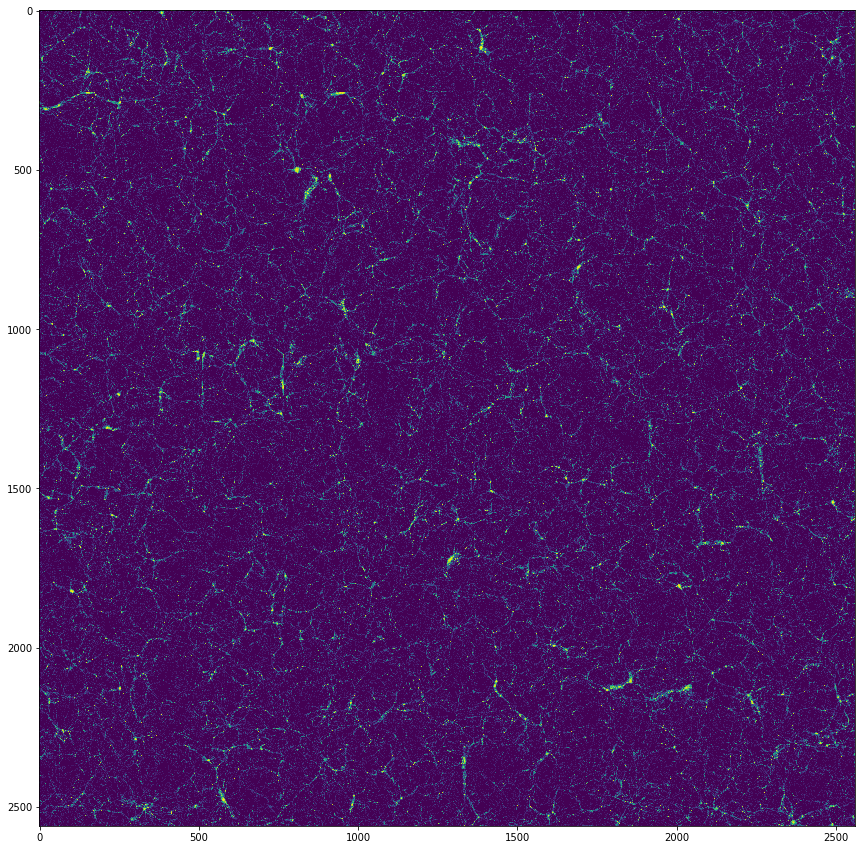

In [41]:
plt.figure(figsize=(15,15))
utils.draw_images(input_img,nx=10,ny=10,px=spix,py=spix)

Let us make small patches of 64 :-)

In [42]:
ns = 64
cut = spix//ns
img_small = np.zeros([nsamples*cut*cut, ns, ns])
for i in range(cut):
    for j in range(cut):
        k = j + i*cut 
        img_small[k*nsamples:(k+1)*nsamples,:,:] = input_img[:,i*ns:(i+1)*ns,j*ns:(j+1)*ns]


# # Reduce the size
# ns = 64
# cut = spix//ns
# img_small = input_img[:,:ns,:ns].copy()
# del input_img

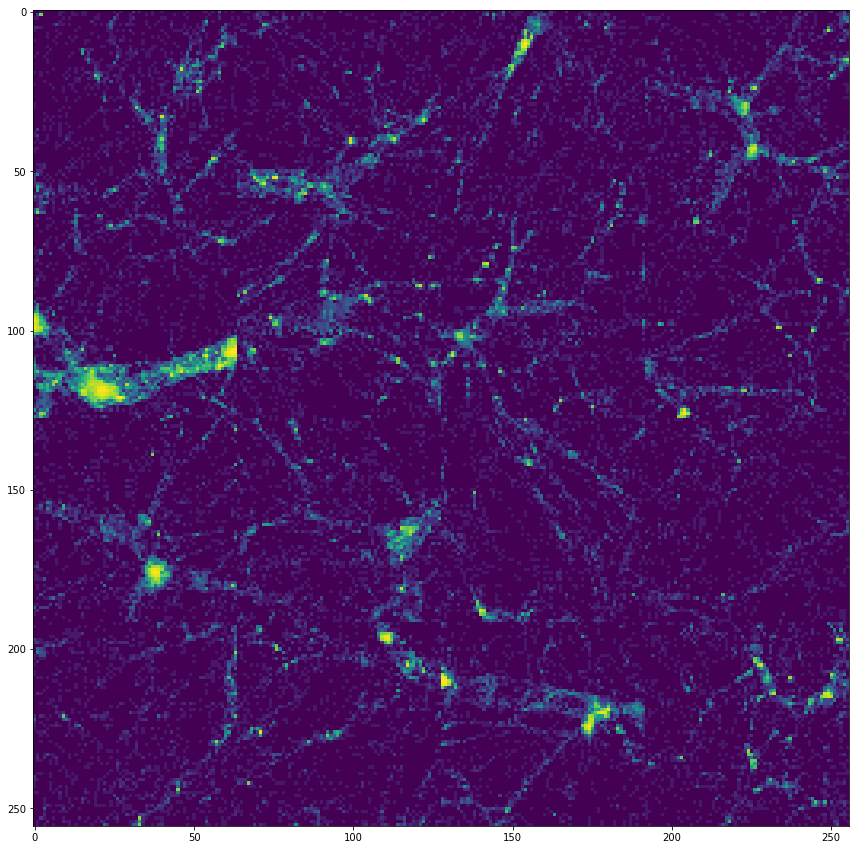

In [43]:
plt.figure(figsize=(15,15))
utils.draw_images(img_small,nx=4,ny=4,px=ns,py=ns)

# A) Train a small GAN

In [44]:
def current_time_str():
    import time, datetime
    d = datetime.datetime.fromtimestamp(time.time())
    return str(d.year)+ '_' + str(d.month)+ '_' + str(d.day)+ '_' + str(d.hour)+ '_' + str(d.minute)

time_str = current_time_str() 
global_path = '../../saved_result/'

In [55]:
latent_dim = 100

bn = False

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2]
params_discriminator['nfilter'] = [16, 32, 64]
params_discriminator['shape'] = [[5, 5],[5, 5], [3, 3]]
params_discriminator['batch_norm'] = [bn, bn, bn]
params_discriminator['full'] = [128]
params_discriminator['summary'] = True

params_encoder = dict()
params_encoder['stride'] = [2, 2, 2]
params_encoder['nfilter'] = [16, 32, 64]
params_encoder['shape'] = [[5, 5],[5, 5], [3, 3]]
params_encoder['batch_norm'] = [bn, bn, bn]
params_encoder['full'] = [128]
params_encoder['summary'] = True

params_generator = dict()
params_generator['stride'] = [2, 2, 2]
params_generator['latent_dim'] = latent_dim
params_generator['nfilter'] = [64, 32, 1]
params_generator['shape'] = [[3, 3],[5, 5], [5, 5]]
params_generator['batch_norm'] = [bn, bn]
params_generator['full'] = [8*8*64]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['weight_l2'] = 0.1
params_optimization['batch_size'] = 16
params_optimization['optimizer'] = 'adam' # rmsprop / adam
params_optimization['disc_learning_rate'] = 1e-5
params_optimization['gen_learning_rate'] = 1e-5
params_optimization['enc_learning_rate'] = 1e-5
params_optimization['beta1'] = 0.9
params_optimization['beta2'] = 0.9
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 50

params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['encoder'] = params_encoder
params['optimization'] = params_optimization

params['image_size'] = [ns, ns]
params['sum_every'] = 200
params['viz_every'] = 200
params['save_every'] = 2000
params['name'] = 'WVEEGAN{}'.format(ns)
params['summary_dir'] = global_path + params['name'] + '_' + time_str +'summary/'
params['save_dir'] = global_path + params['name'] + '_' + time_str + 'checkpoints/'

params['clip_max_real'] = False
params['log_clip'] = 0.1
params['sigma_smooth'] = 1
params['k'] = k





In [ ]:
from model import WVeeGanModel
from gan import GAN

obj = GAN(params, WVeeGanModel)

Generator 
------------------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 4096 outputs
         Size of the variables: (?, 4096)
     Reshape to (?, 8, 8, 64)
     1 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 16, 16, 64)
     2 Deconv layer with 32 channels
         Batch norm
         Size of the variables: (?, 32, 32, 32)
     3 Deconv layer with 1 channels
         Size of the variables: (?, 64, 64, 1)
    Non lienarity: tanh
     The output is of size (?, 64, 64, 1)
------------------------------------------------------------

Encoder 
------------------------------------------------------------
     The input is of size (?, 64, 64, 1)
     0 Conv layer with 16 channels
         Size of the variables: (?, 32, 32, 16)
     1 Conv layer with 32 channels
         Size of the variables: (?, 16, 16, 32)
     2 Conv layer with 64 channels
         Size of the variables: (?, 8, 8, 64)
     R

In [ ]:
obj.train(img_small)


Erease recursively directory: ../../saved_result/WVEEGAN64_2018_1_11_18_40summary/
Epoch: [ 0] [  99/15000] Counter:100	( 1.0 min	25.57 examples/sec	0.626 sec/batch)	L_Disc:-16.06766319	L_Gen:3.42494106
Epoch: [ 0] [ 199/15000] Counter:200	( 2.1 min	25.95 examples/sec	0.617 sec/batch)	L_Disc:-18.56661224	L_Gen:3.56747079
 [*] [Fake, Real] Min [14.164, 0.146],	Median [14.449,0.779],	Mean [1.447E+01,2.129E+00],	 Max [1.493E+01,1.278E+02],	 Var [1.675E-02,5.851E+01]
 [*] [Comp, Fake, Real] PeakDistance:[21.374, 0.196, 0.161]	CrossPS:[0.076, 0.004, 12.384]	PSD_Diff:204553.997
 [*] New PSD Low achieved 2074912.856258 (was 10000000000.000000)
 [*] New Log PSD Low achieved 2954.397479 (was 10000.000000)
Epoch: [ 0] [ 299/15000] Counter:300	( 3.2 min	24.40 examples/sec	0.656 sec/batch)	L_Disc:-19.40470505	L_Gen:2.32473445
Epoch: [ 0] [ 399/15000] Counter:400	( 4.2 min	25.95 examples/sec	0.617 sec/batch)	L_Disc:-19.53049469	L_Gen:0.94079351
 [*] [Fake, Real] Min [12.680, 0.156],	Median [13.243,

In [28]:

gen_sample, gen_sample_raw = wveegan_obj.generate()
        

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../saved_result/WVEEGAN/2018_1_5_11_26_size_64/checkpoints/veegan-30000


/data/.virtualenvs/fma/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


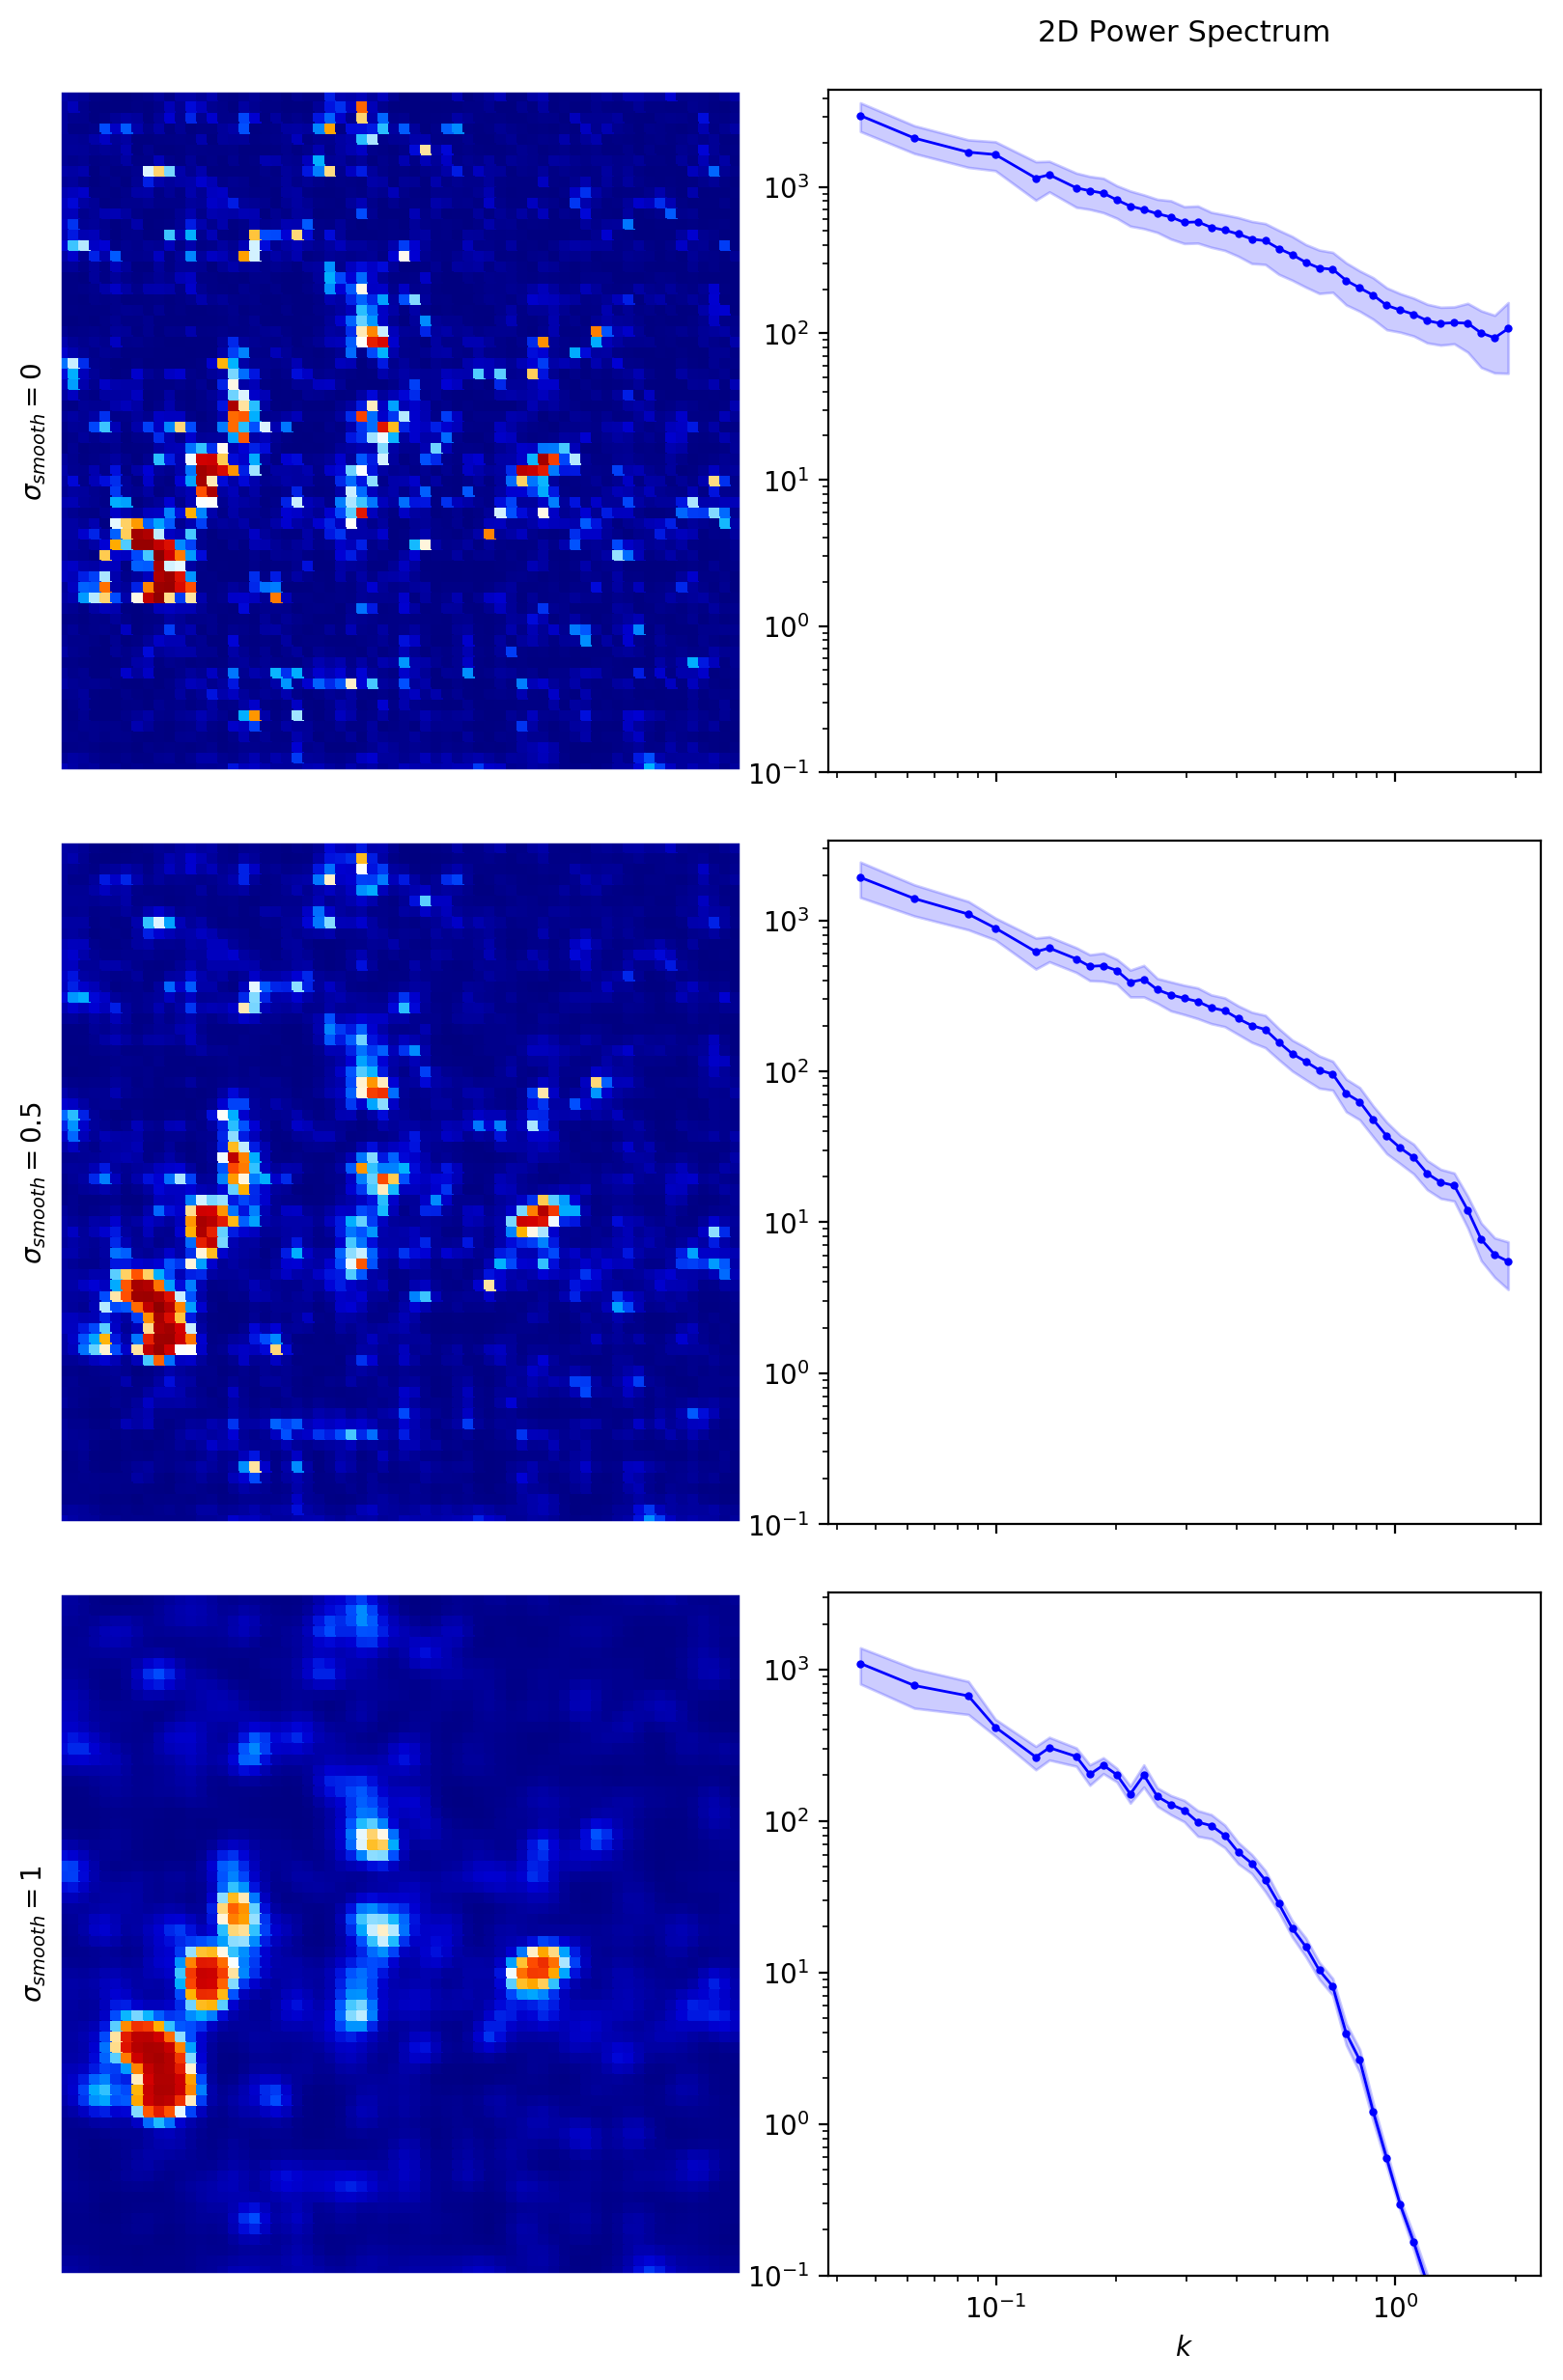

In [29]:
import plot

plot.plot_images_psd(gen_sample_raw,'' , sigma_smooth = [0,0.5,1])
